In [7]:
# starter_nifty_model.py
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import ta  # pip install ta

# ---------- PARAMETERS ----------
CSV_PATH = "nifty_minute.csv"   # change to your file
DT_COL = "date"
HORIZON = 1        # minutes ahead to predict (set 5 or 10 for 5/10-min)
LAST_T = 10        # minutes of history used (set 5 to use last 5 minutes)
TAU_PCT = 0.0001   # threshold to call move significant (0.01% = 0.0001). tune this.
TRAIN_END = "2023-12-31"   # end date for training (inclusive)
VAL_END = "2024-12-31"     # end date for validation
# --------------------------------

# 1) Load
df = pd.read_csv(CSV_PATH)
df[DT_COL] = pd.to_datetime(df[DT_COL])
df = df.sort_values(DT_COL).reset_index(drop=True)
df = df.set_index(DT_COL)

# if volume column strings or zeroes, convert
if "volume" in df.columns:
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)

# Keep market hours optionally (example Indian market)
df = df.between_time("09:15", "15:30")

# 2) Basic features
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['open']  = pd.to_numeric(df['open'], errors='coerce')
df['high']  = pd.to_numeric(df['high'], errors='coerce')
df['low']   = pd.to_numeric(df['low'], errors='coerce')

df['return_1'] = df['close'].pct_change()  # simple pct change
df['logret_1'] = np.log(df['close'] / df['close'].shift(1))

# 3) Technical indicators (using ta)
# Note: ta expects columns named 'high','low','close','volume'
df['sma_5']  = ta.trend.SMAIndicator(df['close'], window=5, fillna=True).sma_indicator()
df['sma_10'] = ta.trend.SMAIndicator(df['close'], window=10, fillna=True).sma_indicator()
df['ema_8']  = ta.trend.EMAIndicator(df['close'], window=8, fillna=True).ema_indicator()
df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14, fillna=True).rsi()
bb = ta.volatility.BollingerBands(df['close'], window=20, fillna=True)
df['bb_h'] = bb.bollinger_hband()
df['bb_l'] = bb.bollinger_lband()
df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14, fillna=True)

# 4) Build lag features flattened over last_T minutes
def build_lagged_features(df, last_t):
    X_rows = []
    idxs = []
    for i in range(last_t, len(df) - HORIZON):
        window = df.iloc[i-last_t:i]  # previous last_t rows, not including current i
        cur_time = df.index[i]
        # Flatten selected columns (close, return_1, volume, sma_5, rsi_14)
        feat = {}
        for j, (_, row) in enumerate(window.iterrows(), start=1):
            lag = last_t - (j-1)  # 10 -> most recent in window has lag 1
            feat[f'close_lag_{lag}'] = row['close']
            feat[f'ret_lag_{lag}']   = row['return_1']
            feat[f'vol_lag_{lag}']   = row.get('volume', 0)
        # add some snapshot features at time i (just before predicting next)
        snap = df.iloc[i]
        feat['close_now'] = snap['close']
        feat['sma_5_now'] = snap['sma_5']
        feat['ema_8_now'] = snap['ema_8']
        feat['rsi_14_now'] = snap['rsi_14']
        feat['atr_14_now'] = snap['atr_14']
        X_rows.append(feat)
        idxs.append(cur_time)
    X = pd.DataFrame(X_rows, index=idxs)
    return X

X = build_lagged_features(df, LAST_T)

# 5) Build labels (multiclass)
# For each time t (aligned with X.index) we used window ending at index t (close_now at t)
# Label compares close at t+HORIZON to close_now
future_close = df['close'].shift(-HORIZON)
aligned_future = future_close.loc[X.index]
current_close = X['close_now']
ret_h = (aligned_future.values - current_close.values) / current_close.values
# label mapping: 0=down,1=neutral,2=up
labels = np.where(ret_h > TAU_PCT, 2, np.where(ret_h < -TAU_PCT, 0, 1))
y = pd.Series(labels, index=X.index)

# Remove rows with NaN in future (end of series) or any NaN features
mask = (~np.isnan(ret_h)) & (~X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

# 6) Train/Val/Test split by date (no shuffle)
dates = X.index.normalize()
train_mask = dates <= pd.to_datetime(TRAIN_END)
val_mask   = (dates > pd.to_datetime(TRAIN_END)) & (dates <= pd.to_datetime(VAL_END))
test_mask  = dates > pd.to_datetime(VAL_END)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val     = X.loc[val_mask], y.loc[val_mask]
X_test, y_test   = X.loc[test_mask], y.loc[test_mask]

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# 7) Scale numeric features (optional)
scaler = StandardScaler()
num_cols = X_train.columns.tolist()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# 8) LightGBM dataset
dtrain = lgb.Dataset(X_train_s, label=y_train)
dval   = lgb.Dataset(X_val_s, label=y_val, reference=dtrain)

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

bst = lgb.train(params, dtrain, valid_sets=[dtrain, dval], valid_names=['train','val'],
                num_boost_round=1000, early_stopping_rounds=50, verbose_eval=50)

# 9) Evaluate on validation and test
def eval_and_report(model, Xs, ys, scaler, name="set"):
    Xs_s = pd.DataFrame(scaler.transform(Xs[num_cols]), columns=num_cols, index=Xs.index)
    probs = model.predict(Xs_s)
    preds = np.argmax(probs, axis=1)
    print(f"--- {name} classification report ---")
    print(classification_report(ys, preds, digits=4))
    cm = confusion_matrix(ys, preds)
    print("Confusion matrix:\n", cm)
    # directional accuracy (treat neutral as no trade)
    dir_acc = np.mean(preds == ys)
    print("Overall accuracy:", dir_acc)

eval_and_report(bst, X_val, y_val, scaler, "validation")
eval_and_report(bst, X_test, y_test, scaler, "test")

# 10) Example inference function: feed last LAST_T minutes dataframe (most recent) and get probs
def predict_from_recent(model, recent_df, scaler, last_t=LAST_T):
    # recent_df must be a chronological DataFrame containing at least last_t + current row
    # We will use the last 'last_t' rows preceding the prediction time (exclude future)
    # Build same features as build_lagged_features but for the last available time
    tmp = recent_df.copy()
    tmp['close'] = tmp['close'].astype(float)
    # compute the indicators as before if not present
    tmp['sma_5'] = ta.trend.SMAIndicator(tmp['close'], window=5, fillna=True).sma_indicator()
    tmp['ema_8'] = ta.trend.EMAIndicator(tmp['close'], window=8, fillna=True).ema_indicator()
    tmp['rsi_14'] = ta.momentum.RSIIndicator(tmp['close'], window=14, fillna=True).rsi()
    tmp['atr_14'] = ta.volatility.average_true_range(tmp['high'], tmp['low'], tmp['close'], window=14, fillna=True)
    feat = {}
    window = tmp.iloc[-last_t:]
    for j, (_, row) in enumerate(window.iterrows(), start=1):
        lag = last_t - (j-1)
        feat[f'close_lag_{lag}'] = row['close']
        feat[f'ret_lag_{lag}']   = row['close'] / (tmp['close'].shift(1).iloc[-last_t + j - 1]) - 1 if j>1 else 0.0
        feat[f'vol_lag_{lag}']   = row.get('volume', 0)
    snap = tmp.iloc[-1]
    feat['close_now'] = snap['close']
    feat['sma_5_now'] = snap['sma_5']
    feat['ema_8_now'] = snap['ema_8']
    feat['rsi_14_now'] = snap['rsi_14']
    feat['atr_14_now'] = snap['atr_14']
    Xnew = pd.DataFrame([feat])
    Xnew = Xnew[num_cols]  # ensure column order
    Xnew_s = pd.DataFrame(scaler.transform(Xnew), columns=num_cols)
    probs = model.predict(Xnew_s)[0]
    classes = {0: 'Down', 1: 'Neutral', 2: 'Up'}
    return {classes[i]: float(probs[i]) for i in range(len(probs))}

# Usage example: using last LAST_T rows from df (the full series)
recent_sample = df.iloc[-(LAST_T+1):]  # keep last_T +1 to include current snapshot
print("Prediction on most recent:", predict_from_recent(bst, recent_sample, scaler))

Sizes: (828994, 35) (92454, 35) (53249, 35)


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [9]:
# starter_nifty_model.py
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
import ta  # pip install ta

# ---------- PARAMETERS ----------
CSV_PATH = "nifty_minute.csv"   # change to your file
DT_COL = "date"
HORIZON = 1        # minutes ahead to predict (set 5 or 10 for 5/10-min)
LAST_T = 10        # minutes of history used (set 5 to use last 5 minutes)
TAU_PCT = 0.0001   # threshold to call move significant (0.01% = 0.0001). tune this.
TRAIN_END = "2023-12-31"   # end date for training (inclusive)
VAL_END = "2024-12-31"     # end date for validation
# --------------------------------

# 1) Load
df = pd.read_csv(CSV_PATH)
df[DT_COL] = pd.to_datetime(df[DT_COL])
df = df.sort_values(DT_COL).reset_index(drop=True)
df = df.set_index(DT_COL)

# if volume column strings or zeroes, convert
if "volume" in df.columns:
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)

# Keep market hours optionally (example Indian market)
df = df.between_time("09:15", "15:30")

# 2) Basic features
df['close'] = pd.to_numeric(df['close'], errors='coerce')
df['open']  = pd.to_numeric(df['open'], errors='coerce')
df['high']  = pd.to_numeric(df['high'], errors='coerce')
df['low']   = pd.to_numeric(df['low'], errors='coerce')

df['return_1'] = df['close'].pct_change()  # simple pct change
df['logret_1'] = np.log(df['close'] / df['close'].shift(1))

# 3) Technical indicators (using ta)
# Note: ta expects columns named 'high','low','close','volume'
df['sma_5']  = ta.trend.SMAIndicator(df['close'], window=5, fillna=True).sma_indicator()
df['sma_10'] = ta.trend.SMAIndicator(df['close'], window=10, fillna=True).sma_indicator()
df['ema_8']  = ta.trend.EMAIndicator(df['close'], window=8, fillna=True).ema_indicator()
df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14, fillna=True).rsi()
bb = ta.volatility.BollingerBands(df['close'], window=20, fillna=True)
df['bb_h'] = bb.bollinger_hband()
df['bb_l'] = bb.bollinger_lband()
df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14, fillna=True)

# 4) Build lag features flattened over last_T minutes
def build_lagged_features(df, last_t):
    X_rows = []
    idxs = []
    for i in range(last_t, len(df) - HORIZON):
        window = df.iloc[i-last_t:i]  # previous last_t rows, not including current i
        cur_time = df.index[i]
        # Flatten selected columns (close, return_1, volume, sma_5, rsi_14)
        feat = {}
        for j, (_, row) in enumerate(window.iterrows(), start=1):
            lag = last_t - (j-1)  # 10 -> most recent in window has lag 1
            feat[f'close_lag_{lag}'] = row['close']
            feat[f'ret_lag_{lag}']   = row['return_1']
            feat[f'vol_lag_{lag}']   = row.get('volume', 0)
        # add some snapshot features at time i (just before predicting next)
        snap = df.iloc[i]
        feat['close_now'] = snap['close']
        feat['sma_5_now'] = snap['sma_5']
        feat['ema_8_now'] = snap['ema_8']
        feat['rsi_14_now'] = snap['rsi_14']
        feat['atr_14_now'] = snap['atr_14']
        X_rows.append(feat)
        idxs.append(cur_time)
    X = pd.DataFrame(X_rows, index=idxs)
    return X

X = build_lagged_features(df, LAST_T)

# 5) Build labels (multiclass)
# For each time t (aligned with X.index) we used window ending at index t (close_now at t)
# Label compares close at t+HORIZON to close_now
future_close = df['close'].shift(-HORIZON)
aligned_future = future_close.loc[X.index]
current_close = X['close_now']
ret_h = (aligned_future.values - current_close.values) / current_close.values
# label mapping: 0=down,1=neutral,2=up
labels = np.where(ret_h > TAU_PCT, 2, np.where(ret_h < -TAU_PCT, 0, 1))
y = pd.Series(labels, index=X.index)

# Remove rows with NaN in future (end of series) or any NaN features
mask = (~np.isnan(ret_h)) & (~X.isna().any(axis=1))
X = X.loc[mask]
y = y.loc[mask]

# 6) Train/Val/Test split by date (no shuffle)
dates = X.index.normalize()
train_mask = dates <= pd.to_datetime(TRAIN_END)
val_mask   = (dates > pd.to_datetime(TRAIN_END)) & (dates <= pd.to_datetime(VAL_END))
test_mask  = dates > pd.to_datetime(VAL_END)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val     = X.loc[val_mask], y.loc[val_mask]
X_test, y_test   = X.loc[test_mask], y.loc[test_mask]

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# 7) Scale numeric features (optional)
scaler = StandardScaler()
num_cols = X_train.columns.tolist()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# 8) LightGBM dataset
dtrain = lgb.Dataset(X_train_s, label=y_train)
dval   = lgb.Dataset(X_val_s, label=y_val, reference=dtrain)

params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}


Sizes: (828994, 35) (92454, 35) (53249, 35)


TypeError: train() got an unexpected keyword argument 'early_stopping_rounds'

In [21]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

bst = LGBMClassifier( objective='multiclass', num_class=3, learning_rate=0.05, n_estimators=1000, num_leaves=31, random_state=42 )

bst.fit( X_train_s, y_train, eval_set=[(X_val_s, y_val)], eval_metric='multi_logloss', callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)] )


# 9) Evaluate on validation and test
def eval_and_report(model, Xs, ys, scaler, name="set"):
    Xs_s = pd.DataFrame(scaler.transform(Xs[num_cols]), columns=num_cols, index=Xs.index)
    probs = model.predict_proba(Xs_s) 
    preds = np.argmax(probs, axis=1)
    print(f"--- {name} classification report ---")
    print(classification_report(ys, preds, digits=4))
    cm = confusion_matrix(ys, preds)
    print("Confusion matrix:\n", cm)
    # directional accuracy (treat neutral as no trade)
    dir_acc = np.mean(preds == ys)
    print("Overall accuracy:", dir_acc)

eval_and_report(bst, X_val, y_val, scaler, "validation")
eval_and_report(bst, X_test, y_test, scaler, "test")

# 10) Example inference function: feed last LAST_T minutes dataframe (most recent) and get probs
def predict_from_recent(model, recent_df, scaler, last_t=LAST_T, required_indicator_cols=None):
    """
    recent_df: chronological dataframe ending at the current time (index ascending).
               Must include raw OHLCV and the indicator columns used in training.
    model: trained sklearn LightGBM model (LGBMClassifier) or similar with predict_proba()
    scaler: fitted StandardScaler used in training
    last_t: number of minutes of history used in feature construction
    required_indicator_cols: list of indicator column names expected (optional)
    """
    if required_indicator_cols is None:
        required_indicator_cols = ['sma_5','ema_8','rsi_14','atr_14']
    # Ensure recent_df is sorted ascending by index (old -> new)
    tmp = recent_df.copy()
    tmp = tmp.sort_index()
    # Basic checks
    if len(tmp) < last_t:
        raise ValueError(f"recent_df must contain at least last_t={last_t} rows; got {len(tmp)}")
    missing = [c for c in required_indicator_cols if c not in tmp.columns]
    if missing:
        raise ValueError(f"recent_df is missing required indicator columns: {missing}. Compute them on historical data first.")
    # Build features using the last 'last_t' rows (exclude any future)
    window = tmp.iloc[-last_t:]  # last_t rows chronological
    feat = {}
    # when training we used close_lag_{1..last_t} where lag 1 = most recent
    for j in range(last_t):
        row = window.iloc[-(j+1)]  # most recent first
        lag = j+1
        feat[f'close_lag_{lag}'] = float(row['close'])
        # compute return compared to previous row if available
        try:
            prev_idx = window.index[-(j+2)]
            prev_close = tmp.loc[prev_idx, 'close']
            feat[f'ret_lag_{lag}'] = float(row['close'] / prev_close - 1.0)
        except Exception:
            feat[f'ret_lag_{lag}'] = 0.0
        feat[f'vol_lag_{lag}'] = float(row.get('volume', 0.0))
    # snapshot features at current time = last row of tmp
    snap = tmp.iloc[-1]
    feat['close_now']  = float(snap['close'])
    feat['sma_5_now']  = float(snap['sma_5'])
    feat['ema_8_now']  = float(snap['ema_8'])
    feat['rsi_14_now'] = float(snap['rsi_14'])
    feat['atr_14_now'] = float(snap['atr_14'])
    # Construct DataFrame with same column ordering as training (num_cols from your training script)
    Xnew = pd.DataFrame([feat])
    # Ensure the columns exist in the same order as training num_cols
    missing_cols = [c for c in num_cols if c not in Xnew.columns]
    if missing_cols:
        # If some training columns missing, fill with zeros to keep shape consistent
        for c in missing_cols:
            Xnew[c] = 0.0
    Xnew = Xnew[num_cols]
    # Scale and predict
    Xnew_s = pd.DataFrame(scaler.transform(Xnew), columns=num_cols)
    probs = model.predict_proba(Xnew_s)[0]
    classes = {0: 'Down', 1: 'Neutral', 2: 'Up'}
    return {classes[i]: float(probs[i]) for i in range(len(probs))}

# Usage example: using last LAST_T rows from df (the full series)
recent_sample = df.iloc[-(LAST_T+1):]  # keep last_T +1 to include current snapshot
print("Prediction on most recent:", predict_from_recent(bst, recent_sample, scaler))

Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.06997
[100]	valid_0's multi_logloss: 1.06775
[150]	valid_0's multi_logloss: 1.0678
Early stopping, best iteration is:
[136]	valid_0's multi_logloss: 1.06769
--- validation classification report ---
              precision    recall  f1-score   support

           0     0.3815    0.1908    0.2544     30204
           1     0.4746    0.5074    0.4904     31811
           2     0.3649    0.5196    0.4287     30439

    accuracy                         0.4080     92454
   macro avg     0.4070    0.4059    0.3912     92454
weighted avg     0.4081    0.4080    0.3930     92454

Confusion matrix:
 [[ 5764  8915 15525]
 [ 3675 16140 11996]
 [ 5670  8954 15815]]
Overall accuracy: 0.40797585826465055
--- test classification report ---
              precision    recall  f1-score   support

           0     0.3762    0.1925    0.2547     16817
           1     0.5141    0.5530    0.5329     19482
         

Backtest metrics: {'final_equity': 46895.229129577725, 'total_return_abs': -53104.770870422275, 'total_return_pct': -0.5310477087042228, 'sharpe_approx': -77.8687808492092, 'max_drawdown': -0.5312072934403747}


<Axes: title={'center': 'Equity curve'}>

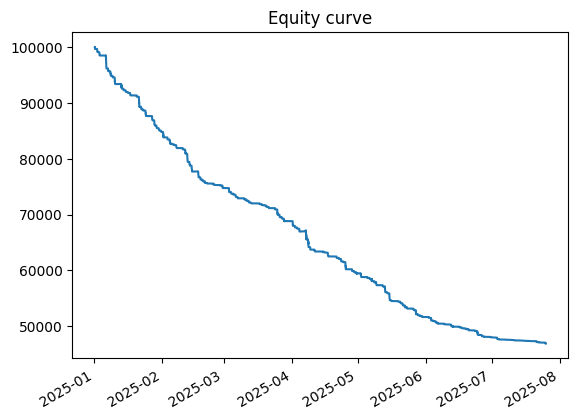

In [22]:
import numpy as np
import pandas as pd

# Backtest params -- tune these
INITIAL_CAPITAL = 100000.0
POSITION_SIZE = 0.2         # fraction of equity to allocate when entering a trade (0..1)
ROUND_TRIP_COST = 0.0003    # fraction cost per round trip (0.03%)  (spread+commissions+slippage)
EXECUTE_ON = 'next_close'   # 'next_close' or 'next_open' (we'll use next_close)
MIN_PROB_THRESHOLD = 0.40   # require predicted class prob >= threshold to act; otherwise be flat

# Map model numeric classes to labels used earlier
CLASS_TO_LABEL = {0: 'Down', 1: 'Neutral', 2: 'Up'}

# Choose series to trade: use your test set timeframe (X_test index aligned with times)
# We'll create a DataFrame containing for each timestamp:
# - price_t (close at time t)
# - price_t_plus (execution price: close at t+HORIZON)
# - model_probs, model_pred
# - trade signal and position
def build_signals_for_times(model, scaler, X_df, raw_df, horizon=HORIZON, min_prob=MIN_PROB_THRESHOLD):
    """
    model: trained classifier with predict_proba
    scaler: StandardScaler used in training
    X_df: feature DataFrame used earlier (X_test or X_val etc), indexed by timestamp t (snapshot time)
    raw_df: original OHLCV dataframe indexed by timestamps (contains close)
    horizon: prediction horizon in minutes (must match training)
    returns: DataFrame with columns: price_t, price_exec (t+horizon close), probs, pred_class, pred_label, signal
    """
    # scale features used for model input
    Xs_s = pd.DataFrame(scaler.transform(X_df[num_cols]), columns=num_cols, index=X_df.index)
    probs = model.predict_proba(Xs_s)                # shape (n_rows, 3)
    preds = np.argmax(probs, axis=1)
    df_sign = pd.DataFrame(index=X_df.index)
    df_sign['price_t'] = raw_df['close'].reindex(X_df.index)
    # execution price is close at t+horizon
    df_sign['price_exec'] = raw_df['close'].shift(-horizon).reindex(X_df.index)
    df_sign['pred_class'] = preds
    df_sign['pred_label'] = df_sign['pred_class'].map(CLASS_TO_LABEL)
    # store max prob and prob per class
    df_sign['prob_max'] = probs.max(axis=1)
    df_sign['prob_up']  = probs[:, 2]
    df_sign['prob_neu'] = probs[:, 1]
    df_sign['prob_dn']  = probs[:, 0]
    # trading decision: only act if prob_max >= min_prob and pred != Neutral
    def decide(row):
        if row['prob_max'] < min_prob:
            return 0  # flat
        if row['pred_label'] == 'Up':
            return 1  # long
        if row['pred_label'] == 'Down':
            return -1 # short
        return 0
    df_sign['signal'] = df_sign.apply(decide, axis=1)
    # drop rows where price_exec is NaN (end of series)
    df_sign = df_sign.dropna(subset=['price_exec'])
    return df_sign

# simple P&L backtest runner
def run_backtest(df_sign, initial_capital=INITIAL_CAPITAL, position_size=POSITION_SIZE, round_trip_cost=ROUND_TRIP_COST):
    """
    df_sign: DataFrame from build_signals_for_times, indexed by time t, containing price_t, price_exec, signal (1/0/-1)
    we assume we open position at price_exec of next minute and close at next signal change (or flip).
    This simple implementation opens a new position every minute according to signal and closes it at next exec price.
    """
    equity = initial_capital
    equity_hist = []
    cash = initial_capital
    # track current open position size and direction (we'll use per-minute flat-trading: enter & exit each minute)
    # For this simple per-minute strategy: we enter at price_exec[t] based on signal[t] and exit at price_exec[t+1] when next row executes.
    times = df_sign.index
    n = len(times)
    # we'll compute P&L per row as holding until next price_exec (t->t+horizon), so actual exit price is df_sign.price_exec shifted by -1? 
    # Simpler and consistent: since price_exec is price at t+horizon, and next row's price_exec is at (t+1)+horizon,
    # our 1-minute holding P&L = (price_exec_next - price_exec_current) for long exposures started at current price_exec.
    # So compute returns based on forward change in execution price.
    price_exec = df_sign['price_exec'].values
    signals = df_sign['signal'].values.astype(int)
    probmax = df_sign['prob_max'].values
    # compute next price for exit (shift -1)
    price_exec_next = np.roll(price_exec, -1)
    price_exec_next[-1] = price_exec[-1]  # last row we consider no exit move (or drop last row earlier)
    equity_times = []
    pos_sizes = []
    pnl_list = []
    # We'll do per-row trade: for each row t, if signal != 0, we allocate position_size * equity to that trade at price_exec[t]
    # number of units = notional / price_exec[t]; hold until next row and realize P&L = units * (price_exec_next - price_exec)
    for i in range(n-1):  # skip last because no next price to settle (you could drop last earlier)
        sig = signals[i]
        if sig == 0:
            pnl = 0.0
            pos = 0.0
        else:
            entry_price = price_exec[i]
            exit_price  = price_exec_next[i]
            notional = position_size * equity  # allocate fraction of current equity
            units = notional / entry_price
            raw_pnl = units * (exit_price - entry_price) * sig  # sign accounts for short/long
            # transaction costs: apply round trip cost to notional
            tc = round_trip_cost * notional
            pnl = raw_pnl - tc
            pos = notional
        equity = equity + pnl
        equity_hist.append(equity)
        pos_sizes.append(pos)
        pnl_list.append(pnl)
        equity_times.append(df_sign.index[i])
    # assemble result DataFrame
    res = pd.DataFrame(index=equity_times)
    res['equity'] = equity_hist
    res['pnl'] = pnl_list
    res['pos_notional'] = pos_sizes
    return res

# metric helpers
def compute_metrics(equity_series, pnl_series, initial_capital=INITIAL_CAPITAL):
    total_return = equity_series.iloc[-1] - initial_capital
    return_pct = total_return / initial_capital
    # approximate annualized Sharpe: use per-minute returns; convert to daily/annual is rough; we'll do simple ratio
    # compute returns series (pct per step)
    rets = equity_series.pct_change().fillna(0)
    # approximate per-minute mean/std, convert to yearly assuming 252 trading days * 390 minutes per day ~ 98580 minutes
    minutes_per_year = 252 * 390
    mean_min = rets.mean()
    std_min  = rets.std() if rets.std() > 0 else 1e-9
    sharpe_anno = (mean_min / std_min) * np.sqrt(minutes_per_year)
    # max drawdown
    cum = equity_series
    running_max = cum.cummax()
    drawdown = (cum - running_max) / running_max
    max_dd = drawdown.min()
    return {
        'final_equity': float(equity_series.iloc[-1]),
        'total_return_abs': float(total_return),
        'total_return_pct': float(return_pct),
        'sharpe_approx': float(sharpe_anno),
        'max_drawdown': float(max_dd)
    }

# Example run on test set
df_sign_test = build_signals_for_times(bst, scaler, X_test, df, horizon=HORIZON, min_prob=MIN_PROB_THRESHOLD)
res = run_backtest(df_sign_test, initial_capital=INITIAL_CAPITAL, position_size=POSITION_SIZE, round_trip_cost=ROUND_TRIP_COST)
metrics = compute_metrics(res['equity'], res['pnl'])
print("Backtest metrics:", metrics)
# show equity curve
res['equity'].plot(title="Equity curve")

Loading data...
Computing indicators...
Building flattened features...
Sizes: (828995, 35) (92454, 35) (53249, 35)
Training LightGBM classifier...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 828995, number of used features: 25
[LightGBM] [Info] Start training from score -1.093986
[LightGBM] [Info] Start training from score -1.120401
[LightGBM] [Info] Start training from score -1.081838
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.07027
[100]	valid_0's multi_logloss: 1.06779
[150]	valid_0's multi_logloss: 1.06773
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 1.06772
Validation eval:
              precision    recall  f1-score   support

           0  

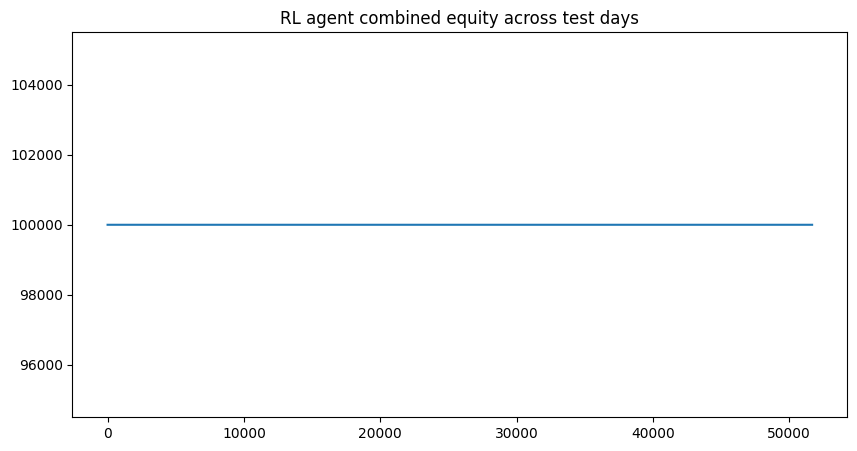

In [9]:
#!/usr/bin/env python3
# train_rl_nifty.py
# End-to-end: load minute CSV -> compute indicators & features -> train LightGBM classifier -> build Gym env -> train PPO -> evaluate

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from lightgbm import LGBMClassifier
import joblib
import ta

# Stable Baselines3
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# ----------------- CONFIG -----------------
CSV_PATH = "nifty_minute.csv"     # path to your minute OHLCV CSV
DATE_COL = "date"
HORIZON = 1       # minutes ahead to predict
LAST_T = 10       # minutes of historical window
TAU_PCT = 0.0001  # label threshold for Up/Down vs Neutral
TRAIN_END_DATE = "2023-12-31"
VAL_END_DATE   = "2024-12-31"
INITIAL_CAPITAL = 100000.0

# RL params
RL_TOTAL_TIMESTEPS = 50000   # increase for real training
RL_LEARNING_RATE = 3e-4
RL_POSITION_SIZE = 0.1       # fraction of equity allocated per trade in env
RL_ROUND_TRIP_COST = 0.0003  # transaction cost fraction
# ------------------------------------------

# ---------- Utilities ----------
def compute_technical_indicators(df):
    # expects df with columns: open, high, low, close, volume
    df = df.copy()
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['open']  = pd.to_numeric(df['open'], errors='coerce')
    df['high']  = pd.to_numeric(df['high'], errors='coerce')
    df['low']   = pd.to_numeric(df['low'], errors='coerce')
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)
    df['return_1'] = df['close'].pct_change().fillna(0)
    df['logret_1'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
    # indicators via ta
    df['sma_5'] = ta.trend.SMAIndicator(df['close'], window=5, fillna=True).sma_indicator()
    df['sma_10'] = ta.trend.SMAIndicator(df['close'], window=10, fillna=True).sma_indicator()
    df['ema_8'] = ta.trend.EMAIndicator(df['close'], window=8, fillna=True).ema_indicator()
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14, fillna=True).rsi()
    bb = ta.volatility.BollingerBands(df['close'], window=20, fillna=True)
    df['bb_h'] = bb.bollinger_hband()
    df['bb_l'] = bb.bollinger_lband()
    df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14, fillna=True)
    return df

def build_flattened_features(df, last_t=LAST_T):
    # Build flattened window features: for each t, include prior last_t closes/returns/volume and snapshot indicators
    rows = []
    idxs = []
    for i in range(last_t, len(df) - HORIZON):
        window = df.iloc[i-last_t:i]
        cur = df.iloc[i]
        feat = {}
        for j in range(last_t):
            row = window.iloc[j]
            lag = last_t - j
            feat[f'close_lag_{lag}'] = row['close']
            feat[f'ret_lag_{lag}'] = row['return_1']
            feat[f'vol_lag_{lag}'] = row['volume']
        # snapshot
        feat['close_now'] = cur['close']
        feat['sma_5_now'] = cur['sma_5']
        feat['ema_8_now'] = cur['ema_8']
        feat['rsi_14_now'] = cur['rsi_14']
        feat['atr_14_now'] = cur['atr_14']
        rows.append(feat)
        idxs.append(df.index[i])
    X = pd.DataFrame(rows, index=idxs)
    return X

def build_labels(df, X_index, horizon=HORIZON, tau=TAU_PCT):
    future = df['close'].shift(-horizon).reindex(X_index)
    current = df['close'].reindex(X_index)
    ret = (future.values - current.values) / current.values
    labels = np.where(ret > tau, 2, np.where(ret < -tau, 0, 1))  # 0=Down,1=Neutral,2=Up
    return pd.Series(labels, index=X_index)

# ---------- Load & preprocess ----------
print("Loading data...")
df = pd.read_csv(CSV_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
# optionally keep market hours
try:
    df = df.between_time("09:15", "15:30")
except Exception:
    pass

print("Computing indicators...")
df = compute_technical_indicators(df)

print("Building flattened features...")
X = build_flattened_features(df, last_t=LAST_T)
y = build_labels(df, X.index, horizon=HORIZON, tau=TAU_PCT)

# align and drop NaNs
mask = ~(X.isna().any(axis=1) | pd.isna(y))
X = X.loc[mask]
y = y.loc[mask]

# Train/Val/Test split by date
dates = X.index.normalize()
train_mask = dates <= pd.to_datetime(TRAIN_END_DATE)
val_mask   = (dates > pd.to_datetime(TRAIN_END_DATE)) & (dates <= pd.to_datetime(VAL_END_DATE))
test_mask  = dates > pd.to_datetime(VAL_END_DATE)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val     = X.loc[val_mask], y.loc[val_mask]
X_test, y_test   = X.loc[test_mask], y.loc[test_mask]

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# Scale numeric features
num_cols = X_train.columns.tolist()
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# ---------- Train a LightGBM classifier (baseline) ----------
print("Training LightGBM classifier...")
clf = LGBMClassifier(objective='multiclass', num_class=3, learning_rate=0.05, n_estimators=1000, num_leaves=31, random_state=42)
from lightgbm import early_stopping, log_evaluation
clf.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], eval_metric='multi_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)])

print("Validation eval:")
probs_val = clf.predict_proba(X_val_s)
preds_val = clf.predict(X_val_s)
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

# merge classifier probs into the original df (so each timestamp has probs)
print("Merging classifier probabilities into df...")
# full X (all timestamps) scaled and predicted
X_all = pd.concat([X_train, X_val, X_test])
X_all_s = pd.DataFrame(scaler.transform(X_all[num_cols]), columns=num_cols, index=X_all.index)
probs_all = clf.predict_proba(X_all_s)
prob_df = pd.DataFrame(probs_all, index=X_all.index, columns=['prob_dn','prob_neu','prob_up'])
# merge into df (left join)
df_with_probs = df.merge(prob_df, left_index=True, right_index=True, how='left')
df_with_probs[['prob_dn','prob_neu','prob_up']] = df_with_probs[['prob_dn','prob_neu','prob_up']].fillna(method='ffill').fillna(1/3)

# ---------- Add this block right after merging classifier probs into df_with_probs ----------
print("Precomputing flattened lag features on full dataframe and merging...")

# Build a full flattened features DataFrame (same as X_all using build_flattened_features earlier)
X_full = build_flattened_features(df_with_probs, last_t=LAST_T)   # uses df_with_probs which has indicators
# X_full index are timestamps where features are valid

# Now merge these flattened features into df_with_probs, aligning on index
# For any timestamp without flattened features (start/end), the merge will produce NaNs — we can drop days with insufficient rows later
df_merged = df_with_probs.merge(X_full, left_index=True, right_index=True, how='left', suffixes=('', '_lag'))

# Optionally forward-fill or leave NaNs — we'll filter days later by required columns
# Replace df_with_probs with df_merged for downstream slicing
df_with_probs = df_merged
print("Merged flattened features. New df columns count:", len(df_with_probs.columns))

# ---------- Build day-wise slices for RL env ----------
def slice_days(df_all):
    days = []
    for date, daydf in df_all.groupby(df_all.index.date):
        daydf = daydf.sort_index()
        # require minimum length
        if len(daydf) >= LAST_T + 10:
            days.append(daydf)
    return days

all_days = slice_days(df_with_probs)
# determine train/val/test day splits by date
dates_all = np.array([d.index[0].date() for d in all_days])
unique_dates = np.array(sorted(list({d.date() for d in df_with_probs.index})))
# Simple split by date strings
train_days = [d for d in all_days if d.index[0].date() <= pd.to_datetime(TRAIN_END_DATE).date()]
val_days   = [d for d in all_days if (pd.to_datetime(TRAIN_END_DATE).date() < d.index[0].date() <= pd.to_datetime(VAL_END_DATE).date())]
test_days  = [d for d in all_days if d.index[0].date() > pd.to_datetime(VAL_END_DATE).date()]

print("Days: train", len(train_days), "val", len(val_days), "test", len(test_days))

# ---------- Define Gym Environment ----------
class MinuteTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, day_df, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST, include_probs=True):
        super().__init__()
        self.day_df = day_df.reset_index()
        self.feature_cols = feature_cols
        self.last_T = last_T
        self.position_size = position_size
        self.round_trip_cost = round_trip_cost
        self.include_probs = include_probs

        obs_dim = last_T * len(feature_cols) + (3 if include_probs else 0) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 0 flat, 1 long, 2 short

        self.ptr = 0
        self.equity = INITIAL_CAPITAL
        self.current_position = 0
        self.position_notional = 0.0
        self.prices = self.day_df['close'].values
        self.exec_prices = np.roll(self.prices, -1)
        self.n = len(self.prices)

    def reset(self):
        self.ptr = self.last_T - 1
        self.equity = INITIAL_CAPITAL
        self.current_position = 0
        self.position_notional = 0.0
        return self._get_obs()

    def step(self, action):
        t = self.ptr
        done = False
        if t >= self.n - 2:
            done = True
            return self._get_obs(), 0.0, done, {'equity': self.equity, 'pnl': 0.0}

        entry_price = float(self.exec_prices[t])
        exit_price = float(self.exec_prices[t+1])
        notional = self.position_size * self.equity
        pnl = 0.0
        if action == 0:
            pnl = 0.0
            self.current_position = 0
            self.position_notional = 0.0
        else:
            sig = 1 if action == 1 else -1
            units = notional / entry_price
            raw_pnl = units * (exit_price - entry_price) * sig
            tc = self.round_trip_cost * notional
            pnl = raw_pnl - tc
            self.current_position = sig
            self.position_notional = notional

        self.equity += pnl
        # small trade penalty to discourage churn
        trade_penalty = -0.0 * notional if action != 0 else 0.0
        reward = pnl + trade_penalty

        self.ptr += 1
        if self.ptr >= self.n - 2:
            done = True

        info = {'equity': self.equity, 'pnl': pnl, 'position': self.current_position}
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        start = self.ptr - (self.last_T - 1)
        window = self.day_df.iloc[start:self.ptr+1]
        feats = window[self.feature_cols].values.flatten()
        probs = window[['prob_dn','prob_neu','prob_up']].iloc[-1].values if self.include_probs else np.array([])
        pos = np.array([float(self.current_position)], dtype=np.float32)
        obs = np.concatenate([feats, probs, pos]).astype(np.float32)
        return obs

    def render(self, mode='human'):
        print(f"ptr={self.ptr}, equity={self.equity:.2f}, pos={self.current_position}")

# ---------- Prepare feature_cols for env observation ----------
# Use the same num_cols from the flattened feature builder (take a subset that are raw time-series features)
# For simplicity choose the lagged close, ret, vol features (3 * LAST_T) and append a few snapshot indicators
lag_cols = []
for lag in range(1, LAST_T+1):
    lag_cols += [f'close_lag_{lag}', f'ret_lag_{lag}', f'vol_lag_{lag}']
snapshot_cols = ['sma_5_now','ema_8_now','rsi_14_now','atr_14_now']
feature_cols = lag_cols + snapshot_cols

# ---------- Create a vectorized environment for training ----------
def make_env_from_days(days_list):
    def _init():
        # pick a random day from days_list for each env instance
        idx = np.random.randint(len(days_list))
        daydf = days_list[idx]
        return MinuteTradingEnv(daydf, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST)
    return _init

if len(train_days) == 0:
    raise RuntimeError("No training days available. Check your dates and CSV.")

print("Creating vectorized training env...")
train_env = DummyVecEnv([make_env_from_days(train_days) for _ in range(4)])  # 4 parallel envs

# ---------- Train PPO ----------
print("Training PPO agent (this will take some time)...")
model_rl = PPO("MlpPolicy", train_env, verbose=1, learning_rate=RL_LEARNING_RATE)
model_rl.learn(total_timesteps=RL_TOTAL_TIMESTEPS)

# Save RL model and scaler and classifier
print("Saving artifacts...")
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(clf, "artifacts/lightgbm_clf.joblib")
model_rl.save("artifacts/ppo_trader")

# ---------- Evaluation on test days ----------
def eval_on_days(model, days_list):
    equity_curves = []
    metrics_list = []
    for daydf in days_list:
        env = MinuteTradingEnv(daydf, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST)
        obs = env.reset()
        done = False
        equities = []
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(int(action))
            equities.append(info['equity'])
        equities = pd.Series(equities, index=daydf.index[LAST_T:LAST_T+len(equities)])
        equity_curves.append(equities)
        # compute simple metrics
        final_equity = equities.iloc[-1]
        total_return = final_equity - INITIAL_CAPITAL
        max_dd = ((equities.cummax() - equities) / equities.cummax()).max()
        metrics_list.append({'date': daydf.index[0].date(), 'final_equity': final_equity, 'total_return': total_return, 'max_drawdown': max_dd})
    return equity_curves, pd.DataFrame(metrics_list)

print("Evaluating RL agent on test days...")
test_equities, test_metrics = eval_on_days(model_rl, test_days)
print(test_metrics.describe())

# Aggregate equity curve across test days by concatenation
if test_equities:
    combined = pd.concat(test_equities)
    combined = combined.sort_index()
    plt.figure(figsize=(10,5))
    plt.plot(combined.values)
    plt.title("RL agent combined equity across test days")
    plt

In [10]:
#!/usr/bin/env python3
# train_rl_nifty_updated.py
# Updated: fixes to ensure env observations match training, add VecNormalize, debug prints.

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import joblib
import ta

# Stable Baselines3
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor

# ----------------- CONFIG -----------------
CSV_PATH = "nifty_minute.csv"     # path to your minute OHLCV CSV
DATE_COL = "date"                 # ensure this matches your CSV
HORIZON = 1       # minutes ahead to predict
LAST_T = 10       # minutes of historical window
TAU_PCT = 0.0001  # label threshold for Up/Down vs Neutral
TRAIN_END_DATE = "2023-12-31"
VAL_END_DATE   = "2024-12-31"
INITIAL_CAPITAL = 100000.0

# RL params
RL_TOTAL_TIMESTEPS = 50000   # increase for real training
RL_LEARNING_RATE = 3e-4
RL_POSITION_SIZE = 0.1       # fraction of equity allocated per trade in env
RL_ROUND_TRIP_COST = 0.0003  # transaction cost fraction
# PPO exploration params
PPO_ENT_COEF = 0.01
PPO_VF_COEF = 0.5
# ------------------------------------------

# ---------- Utilities ----------
def compute_technical_indicators(df):
    df = df.copy()
    df['close'] = pd.to_numeric(df['close'], errors='coerce')
    df['open']  = pd.to_numeric(df['open'], errors='coerce')
    df['high']  = pd.to_numeric(df['high'], errors='coerce')
    df['low']   = pd.to_numeric(df['low'], errors='coerce')
    df['volume'] = pd.to_numeric(df['volume'], errors='coerce').fillna(0)
    df['return_1'] = df['close'].pct_change().fillna(0)
    df['logret_1'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
    df['sma_5'] = ta.trend.SMAIndicator(df['close'], window=5, fillna=True).sma_indicator()
    df['sma_10'] = ta.trend.SMAIndicator(df['close'], window=10, fillna=True).sma_indicator()
    df['ema_8'] = ta.trend.EMAIndicator(df['close'], window=8, fillna=True).ema_indicator()
    df['rsi_14'] = ta.momentum.RSIIndicator(df['close'], window=14, fillna=True).rsi()
    bb = ta.volatility.BollingerBands(df['close'], window=20, fillna=True)
    df['bb_h'] = bb.bollinger_hband()
    df['bb_l'] = bb.bollinger_lband()
    df['atr_14'] = ta.volatility.average_true_range(df['high'], df['low'], df['close'], window=14, fillna=True)
    return df

def build_flattened_features(df, last_t=LAST_T):
    rows = []
    idxs = []
    for i in range(last_t, len(df) - HORIZON):
        window = df.iloc[i-last_t:i]
        cur = df.iloc[i]
        feat = {}
        for j in range(last_t):
            row = window.iloc[j]
            lag = last_t - j
            feat[f'close_lag_{lag}'] = row['close']
            feat[f'ret_lag_{lag}'] = row['return_1']
            feat[f'vol_lag_{lag}'] = row['volume']
        feat['close_now'] = cur['close']
        feat['sma_5_now'] = cur['sma_5']
        feat['ema_8_now'] = cur['ema_8']
        feat['rsi_14_now'] = cur['rsi_14']
        feat['atr_14_now'] = cur['atr_14']
        rows.append(feat)
        idxs.append(df.index[i])
    X = pd.DataFrame(rows, index=idxs)
    return X

def build_labels(df, X_index, horizon=HORIZON, tau=TAU_PCT):
    future = df['close'].shift(-horizon).reindex(X_index)
    current = df['close'].reindex(X_index)
    ret = (future.values - current.values) / current.values
    labels = np.where(ret > tau, 2, np.where(ret < -tau, 0, 1))
    return pd.Series(labels, index=X_index)

# ---------- Load & preprocess ----------
print("Loading data...")
df = pd.read_csv(CSV_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
try:
    df = df.between_time("09:15", "15:30")
except Exception:
    pass

print("Computing indicators...")
df = compute_technical_indicators(df)

print("Building flattened features (training X)...")
X = build_flattened_features(df, last_t=LAST_T)
y = build_labels(df, X.index, horizon=HORIZON, tau=TAU_PCT)
mask = ~(X.isna().any(axis=1) | pd.isna(y))
X = X.loc[mask]
y = y.loc[mask]

dates = X.index.normalize()
train_mask = dates <= pd.to_datetime(TRAIN_END_DATE)
val_mask   = (dates > pd.to_datetime(TRAIN_END_DATE)) & (dates <= pd.to_datetime(VAL_END_DATE))
test_mask  = dates > pd.to_datetime(VAL_END_DATE)

X_train, y_train = X.loc[train_mask], y.loc[train_mask]
X_val, y_val     = X.loc[val_mask], y.loc[val_mask]
X_test, y_test   = X.loc[test_mask], y.loc[test_mask]

print("Sizes:", X_train.shape, X_val.shape, X_test.shape)

# Scale features
num_cols = X_train.columns.tolist()
scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)
X_val_s   = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols, index=X_val.index)
X_test_s  = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols, index=X_test.index)

# ---------- Train LightGBM ----------
print("Training LightGBM classifier...")
clf = LGBMClassifier(objective='multiclass', num_class=3, learning_rate=0.05, n_estimators=1000, num_leaves=31, random_state=42)
from lightgbm import early_stopping, log_evaluation
clf.fit(X_train_s, y_train, eval_set=[(X_val_s, y_val)], eval_metric='multi_logloss',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)])

print("Validation eval:")
preds_val = clf.predict(X_val_s)
print(classification_report(y_val, preds_val))
print(confusion_matrix(y_val, preds_val))

# ---------- Merge classifier probs into df and precompute flattened features ----------
print("Merging classifier probabilities and precomputing features on full df...")
# Predict on entire X (train+val+test) and build prob df aligned to X indices
X_all = pd.concat([X_train, X_val, X_test])
X_all_s = pd.DataFrame(scaler.transform(X_all[num_cols]), columns=num_cols, index=X_all.index)
probs_all = clf.predict_proba(X_all_s)
prob_df = pd.DataFrame(probs_all, index=X_all.index, columns=['prob_dn','prob_neu','prob_up'])

# Merge probs into base df and forward-fill, then build flattened features from df_with_probs
df_with_probs = df.merge(prob_df, left_index=True, right_index=True, how='left')
df_with_probs[['prob_dn','prob_neu','prob_up']] = df_with_probs[['prob_dn','prob_neu','prob_up']].fillna(method='ffill').fillna(1/3)

# Precompute flattened features for the full df_with_probs and merge (ensures day slices include lag cols)
X_full = build_flattened_features(df_with_probs, last_t=LAST_T)
df_merged = df_with_probs.merge(X_full, left_index=True, right_index=True, how='left')
# drop rows without lag features (start/end)
df_merged = df_merged.dropna(subset=[f'close_lag_1'])  # ensure lag cols present
df_with_probs = df_merged.copy()
print("Merged df columns:", len(df_with_probs.columns))

# ---------- Build day-wise slices ----------
def slice_days(df_all):
    days = []
    for date, daydf in df_all.groupby(df_all.index.date):
        daydf = daydf.sort_index()
        # ensure required feature columns exist
        required = [f'close_lag_{i}' for i in range(1, LAST_T+1)] + ['prob_dn','prob_neu','prob_up'] + ['sma_5_now','ema_8_now','rsi_14_now','atr_14_now']
        if set(required).issubset(set(daydf.columns)) and len(daydf) >= LAST_T + 10:
            days.append(daydf)
    return days

all_days = slice_days(df_with_probs)
train_days = [d for d in all_days if d.index[0].date() <= pd.to_datetime(TRAIN_END_DATE).date()]
val_days   = [d for d in all_days if (pd.to_datetime(TRAIN_END_DATE).date() < d.index[0].date() <= pd.to_datetime(VAL_END_DATE).date())]
test_days  = [d for d in all_days if d.index[0].date() > pd.to_datetime(VAL_END_DATE).date()]

print("Days: train", len(train_days), "val", len(val_days), "test", len(test_days))
if len(train_days) == 0:
    raise RuntimeError("No training days available. Check your dates and CSV.")

# ---------- Define Gym Env ----------
class MinuteTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    def __init__(self, day_df, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST, include_probs=True):
        super().__init__()
        self.day_df = day_df.reset_index()
        self.feature_cols = feature_cols
        self.last_T = last_T
        self.position_size = position_size
        self.round_trip_cost = round_trip_cost
        self.include_probs = include_probs

        obs_dim = last_T * len(feature_cols) + (3 if include_probs else 0) + 1
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

        self.ptr = 0
        self.equity = INITIAL_CAPITAL
        self.current_position = 0
        self.position_notional = 0.0
        self.prices = self.day_df['close'].values
        self.exec_prices = np.roll(self.prices, -1)
        self.n = len(self.prices)

    def reset(self):
        self.ptr = self.last_T - 1
        self.equity = INITIAL_CAPITAL
        self.current_position = 0
        self.position_notional = 0.0
        return self._get_obs()

    def step(self, action):
        t = self.ptr
        done = False
        if t >= self.n - 2:
            done = True
            return self._get_obs(), 0.0, done, {'equity': self.equity, 'pnl': 0.0}

        entry_price = float(self.exec_prices[t])
        exit_price = float(self.exec_prices[t+1])
        notional = self.position_size * self.equity
        pnl = 0.0
        if action == 0:
            pnl = 0.0
            self.current_position = 0
            self.position_notional = 0.0
        else:
            sig = 1 if action == 1 else -1
            units = notional / entry_price
            raw_pnl = units * (exit_price - entry_price) * sig
            tc = self.round_trip_cost * notional
            pnl = raw_pnl - tc
            self.current_position = sig
            self.position_notional = notional

        self.equity += pnl
        reward = pnl
        self.ptr += 1
        if self.ptr >= self.n - 2:
            done = True
        info = {'equity': self.equity, 'pnl': pnl, 'position': self.current_position}
        return self._get_obs(), reward, done, info

    def _get_obs(self):
        start = self.ptr - (self.last_T - 1)
        window = self.day_df.iloc[start:self.ptr+1]
        feats = window[self.feature_cols].values.flatten()
        probs = window[['prob_dn','prob_neu','prob_up']].iloc[-1].values if self.include_probs else np.array([])
        pos = np.array([float(self.current_position)], dtype=np.float32)
        obs = np.concatenate([feats, probs, pos]).astype(np.float32)
        return obs

    def render(self, mode='human'):
        print(f"ptr={self.ptr}, equity={self.equity:.2f}, pos={self.current_position}")

# ---------- Prepare feature_cols ----------
lag_cols = []
for lag in range(1, LAST_T+1):
    lag_cols += [f'close_lag_{lag}', f'ret_lag_{lag}', f'vol_lag_{lag}']
snapshot_cols = ['sma_5_now','ema_8_now','rsi_14_now','atr_14_now']
feature_cols = lag_cols + snapshot_cols

# ---------- Create vectorized env with normalization and monitor ----------
def make_env_from_days(days_list):
    def _init():
        idx = np.random.randint(len(days_list))
        daydf = days_list[idx]
        return MinuteTradingEnv(daydf, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST)
    return _init

n_envs = min(4, max(1, len(train_days)//10))
vec_fns = [make_env_from_days(train_days) for _ in range(n_envs)]
train_env = DummyVecEnv(vec_fns)
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=True, clip_obs=10.)
train_env = VecMonitor(train_env)  # records episode rewards

# ---------- Debug: sample obs from train env and a test env ----------
print("Sampling a training observation and a test observation for debugging...")
sample_env = make_env_from_days(train_days)()
obs_sample = sample_env.reset()
print("Train obs shape:", obs_sample.shape, "first 8 values:", obs_sample.flatten()[:8])

test_env0 = MinuteTradingEnv(test_days[0], feature_cols) if len(test_days)>0 else sample_env
obs_test = test_env0.reset()
print("Test obs shape:", obs_test.shape, "first 8 values:", obs_test.flatten()[:8])

# ---------- Train PPO ----------
print("Training PPO agent (this will take some time)...")
model_rl = PPO("MlpPolicy", train_env, verbose=1, learning_rate=RL_LEARNING_RATE, ent_coef=PPO_ENT_COEF, vf_coef=PPO_VF_COEF)
model_rl.learn(total_timesteps=RL_TOTAL_TIMESTEPS)

# Save artifacts
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.joblib")
joblib.dump(clf, "artifacts/lightgbm_clf.joblib")
model_rl.save("artifacts/ppo_trader")

# ---------- Evaluation with action debug ----------
def eval_on_days(model, days_list):
    equity_curves = []
    metrics_list = []
    for daydf in days_list:
        # skip days missing required cols
        required = set(feature_cols + ['prob_dn','prob_neu','prob_up'])
        if not required.issubset(set(daydf.columns)):
            continue
        env = MinuteTradingEnv(daydf, feature_cols, last_T=LAST_T, position_size=RL_POSITION_SIZE, round_trip_cost=RL_ROUND_TRIP_COST)
        obs = env.reset()
        done = False
        equities = []
        actions = []
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            actions.append

Loading data...
Computing indicators...
Building flattened features (training X)...
Sizes: (828995, 35) (92454, 35) (53249, 35)
Training LightGBM classifier...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 828995, number of used features: 25
[LightGBM] [Info] Start training from score -1.093986
[LightGBM] [Info] Start training from score -1.120401
[LightGBM] [Info] Start training from score -1.081838
Training until validation scores don't improve for 50 rounds
[50]	valid_0's multi_logloss: 1.07027
[100]	valid_0's multi_logloss: 1.06779
[150]	valid_0's multi_logloss: 1.06773
Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 1.06772
Validation eval:
              precision    recall  f1-score   support

           0       0.38      0.21      0.27     30204
           